In [1]:
### import kagglehub

# Download latest version
###path = kagglehub.dataset_download("adityajn105/flickr8k")

###print("Path to dataset files:", path)

# loading dataset


In [2]:
import pandas as pd

captions_path = 'captions.txt'
captions_data = pd.read_csv(captions_path, delimiter=',', header=None, names=['image', 'caption'])

print(captions_data.head())


                       image  \
0                      image   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0                                            caption  
1  A child in a pink dress is climbing up a set o...  
2              A girl going into a wooden building .  
3   A little girl climbing into a wooden playhouse .  
4  A little girl climbing the stairs to her playh...  


# re-arrange the dataset since it could be multiple captions to one image


In [3]:
from collections import defaultdict

image_captions = defaultdict(list)
for i, row in captions_data.iterrows():
    image_id, caption = row['image'], row['caption']
    image_captions[image_id].append(caption)

# Example of image ID and corresponding captions
for key, value in list(image_captions.items())[:3]:
    print(f"Image ID: {key}, Captions: {value}")

Image ID: image, Captions: ['caption']
Image ID: 1000268201_693b08cb0e.jpg, Captions: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
Image ID: 1001773457_577c3a7d70.jpg, Captions: ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']


# Split the captions into train and test


In [4]:
import random

# Get unique image IDs
unique_image_ids = list(image_captions.keys())

# Shuffle and split
random.seed(42)
random.shuffle(unique_image_ids)
split_index = int(len(unique_image_ids) * 0.8)

train_image_ids = unique_image_ids[:split_index]
test_image_ids = unique_image_ids[split_index:]

# Split captions dictionary
train_image_captions = {img_id: image_captions[img_id] for img_id in train_image_ids}
test_image_captions = {img_id: image_captions[img_id] for img_id in test_image_ids}

print(f"Training images: {len(train_image_captions)}, Testing images: {len(test_image_captions)}")


Training images: 6473, Testing images: 1619


In [5]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [6]:
base_model = InceptionV3(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

# Extracting Features


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.inception_v3(pretrained=True)
model = model.to(device)
model.eval()  # Set to evaluation mode
images_directory = 'Images/'

# Define a transformation for the images as required by InceptionV3
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to extract features
def extract_features(image_ids, directory):
    features = {}
    for img_name in tqdm(image_ids, desc="Extracting Features"):
        img_path = os.path.join(directory, img_name)
        try:
            # Load and preprocess the image
            image = Image.open(img_path).convert('RGB')
            image = transform(image)
            image = image.unsqueeze(0).to(device)

            # Extract features
            with torch.no_grad():
                feature = model(image)
            features[img_name] = feature.cpu().numpy().flatten() 
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
    return features

# Assuming train_image_ids and test_image_ids are defined
train_image_features = extract_features(train_image_ids, images_directory)
test_image_features = extract_features(test_image_ids, images_directory)



Using device: cuda


c:\Users\xsyyy\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\xsyyy\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting Features:  45%|████▍     | 2882/6473 [00:41<00:49, 72.08it/s]

Error processing image: [Errno 2] No such file or directory: 'Images/image'


Extracting Features: 100%|██████████| 1619/1619 [00:24<00:00, 66.14it/s]


In [8]:
# Retrieve and print the first and second feature vectors
first_image, first_features = list(train_image_features.items())[0]
second_image, second_features = list(train_image_features.items())[1]

# Print the first 10 values of each feature vector
print(f"Image: {first_image}")
print("Feature vector (first 10 values):", len(first_features))

print(f"\nImage: {second_image}")
print("Feature vector (first 10 values):", second_features[:10])

Image: 2874876837_80d178ba9b.jpg
Feature vector (first 10 values): 1000

Image: 636503038_17ca82b50f.jpg
Feature vector (first 10 values): [-1.3920414   0.6404582  -0.15578055 -0.5635513   0.3825234  -1.2052271
  0.99760145 -0.41723517 -1.1220789  -0.30866346]


In [9]:
first_image, first_captions = list(train_image_captions.items())[1]
print(first_captions)

['Three fishers walk over rocks toward water , lake and cloudy sky in background .', 'Three people are standing on rocks near a body of water .', 'Three people are walking on rocks towards a lake .', 'Three people stand with fishing poles on the rocks near the water .', 'Three people walking along rocks , going to go fish']


In [10]:
import pandas as pd

# Create DataFrame from features dictionary
features_df = pd.DataFrame(list(test_image_features.items()), columns=['img_id', 'feature_vec'])

# Create DataFrame from captions dictionary
captions_df = pd.DataFrame(list(test_image_captions.items()), columns=['img_id', 'caption_list'])

# Merge both DataFrames on 'img_id'
combined_df = pd.merge(features_df, captions_df, on='img_id')

# Display the combined DataFrame
combined_df.head()


,img_id,feature_vec,caption_list
0,3302804312_0272091cd5.jpg,"[0.22926496, -0.3635427, 1.2871654, -0.0384187...",[A black and brown dog is running with a tenni...
1,607339469_af851c4119.jpg,"[1.0217429, 0.9820682, -0.6495387, 1.3470335, ...","[A girl in a purple shirt feeding ducks, A gir..."
2,3686924335_3c51e8834a.jpg,"[-1.0176438, 2.0163276, 1.1104608, -0.12992166...","[a dog gets sprayed by a hose ., A dog is bein..."
3,2587017287_888c811b5a.jpg,"[-0.6995304, 0.032755435, -0.6229489, -0.03946...","[A big tan wet dog in shallow water ., A brown..."
4,3109688427_d2e702456c.jpg,"[0.30566406, -0.3652759, -1.2324796, -1.108713...",[A man and two girls look at something in the ...


In [11]:
import pandas as pd

# Create DataFrame from `train_image_features`
df_features = pd.DataFrame(list(test_image_features.items()), columns=["img_id", "feature_vec"])

# Create DataFrame from `train_image_captions`
df_captions = pd.DataFrame(list(test_image_captions.items()), columns=["img_id", "caption_list"])

# Merge DataFrames on `img_id`
test_df = pd.merge(df_features, df_captions, on="img_id")

# Convert `feature_vec` to a string format and combine it with captions
test_df["feature_vec_str"] = test_df["feature_vec"].apply(lambda x: ' '.join(map(str, x)))
test_df["input_text"] = "Image features: " + test_df["feature_vec_str"] + " Caption:"
test_df["target_text"] = test_df["caption_list"].apply(lambda x: ' '.join(x))

test_df = test_df[["input_text", "target_text"]]
test_df.head()


,input_text,target_text
0,Image features: 0.22926496 -0.3635427 1.287165...,A black and brown dog is running with a tennis...
1,Image features: 1.0217429 0.9820682 -0.6495387...,A girl in a purple shirt feeding ducks A girl ...
2,Image features: -1.0176438 2.0163276 1.1104608...,a dog gets sprayed by a hose . A dog is being ...
3,Image features: -0.6995304 0.032755435 -0.6229...,A big tan wet dog in shallow water . A brown d...
4,Image features: 0.30566406 -0.3652759 -1.23247...,A man and two girls look at something in the w...


In [12]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import pandas as pd
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

Using device: cuda


c:\Users\xsyyy\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def generate_caption(img_id):
    image_path = f"Images/{img_id}"
    image = Image.open(image_path)
    
    inputs = processor(image, return_tensors="pt").to(device)
    
    outputs = model.generate(
        **inputs,
        max_length=30,           
        min_length=15,           
        no_repeat_ngram_size=2,  
        num_beams=5             
    )
    

    caption = processor.decode(outputs[0], skip_special_tokens=True)
    return caption


def read_image_ids(file_path):
    image_ids = set()
    with open(file_path, 'r') as f:
        for line in f:
            image_id = line.strip().split(',', 1)[0]  
            image_ids.add(image_id)  
    return list(image_ids)


image_ids = combined_df['img_id']

with open('generated_captions_LLM.txt', 'w') as f:
    for img_id in image_ids:
        try:
            caption = generate_caption(img_id)
            f.write(f"{img_id}|{caption}\n")
            print(f"Generated caption for {img_id}: {caption}")
        except Exception as e:
            print(f"Error generating caption for {img_id}: {e}")

#print(" 'generated_captions_LLM.txt'")

Generated caption for 3302804312_0272091cd5.jpg: a brown and white dog running in the grass with a tennis ball in its mouth
Generated caption for 607339469_af851c4119.jpg: a little girl feeding a duck on the side of a river in a park
Generated caption for 3686924335_3c51e8834a.jpg: a dog jumping in the air to catch a froth of water from a hose attached to a brick wall
Generated caption for 2587017287_888c811b5a.jpg: a brown dog running in the water with a ball in it's mouth
Generated caption for 3109688427_d2e702456c.jpg: a man and a little girl standing on a dirt road with trees in the background
Generated caption for 3529721084_4b405baf54.jpg: two men riding motorcycles down the street on a city street with buildings in the background
Generated caption for 3301754574_465af5bf6d.jpg: a bird flying in the air with a fish in it's beak
Generated caption for 140377584_12bdbdf2f8.jpg: a man climbing up a mountain with a rope attached to his back and a helmet on his head
Generated caption f

In [14]:
first_image, first_captions = list(test_image_captions.items())[0]
print(first_image)
print(first_captions)

3302804312_0272091cd5.jpg
['A black and brown dog is running with a tennis ball in its mouth .', 'A brown and white dog is running with a ball in its mouth on grass in front of a fence .', 'A brown and white dog runs beside a wooden fence with a tennis ball in his mouth .', 'A brown and white dog runs with a tennis ball in its mouth .', 'A brown dog is running by a wooden fence with a ball in its mouth .']


In [15]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

def calculate_bleu(generated_caption, reference_captions):
    generated_tokens = generated_caption.split()
    reference_tokens = [caption.split() for caption in reference_captions]
    chencherry = SmoothingFunction()
    score = sentence_bleu(
        reference_tokens,
        generated_tokens,
        weights=(0.5, 0.5),  # 1-gram 和 2-gram
        smoothing_function=chencherry.method1
    )
    return score

In [16]:
def read_generated_captions(file_path):
    generated_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            image_id, caption = line.strip().split('|', 1)
            generated_dict[image_id] = caption
    return generated_dict

In [21]:
from sentence_transformers import SentenceTransformer, util

model1 = SentenceTransformer('all-MiniLM-L6-v2')
def read_reference_captions(file_path):
    reference_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            image_id, caption = line.strip().split(',', 1)
            if image_id not in reference_dict:
                reference_dict[image_id] = []
            reference_dict[image_id].append(caption)
    return reference_dict

generated_dict = read_generated_captions('generated_captions_LLM.txt')
reference_dict = read_reference_captions('captions.txt')

bleu_scores = []
semantic_scores = []

for image_id, generated_caption in tqdm(generated_dict.items(), desc="Calculating Scores"):
    if image_id in reference_dict:
        reference_captions = reference_dict[image_id]
        
        # Calculate BLEU Score
        bleu_score = calculate_bleu(generated_caption, reference_captions)
        
        # Compute semantic similarity
        gen_embedding = model1.encode(generated_caption, convert_to_tensor=True)
        ref_embeddings = model1.encode(reference_captions, convert_to_tensor=True)
        
        # Calculate the max semantic similarity across all references
        max_similarity = max([util.cos_sim(gen_embedding, ref_embedding).item() for ref_embedding in ref_embeddings])
        
        # Append both scores
        bleu_scores.append({'Image ID': image_id, 'BLEU Score': bleu_score})
        semantic_scores.append({'Image ID': image_id, 'Semantic Similarity': max_similarity})
    else:
        bleu_scores.append({'Image ID': image_id, 'BLEU Score': None})
        semantic_scores.append({'Image ID': image_id, 'Semantic Similarity': None})

# Combine BLEU and semantic scores into a DataFrame
df_bleu = pd.DataFrame(bleu_scores)
df_semantic = pd.DataFrame(semantic_scores)
df = pd.merge(df_bleu, df_semantic, on='Image ID')
print(df.head())

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\xsyyy\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\xsyyy\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

c:\Users\xsyyy\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Calculating Scores:   0%|          | 0/1619 [00:00<?, ?it/s]c:\Users\xsyyy\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Calculating Scores: 100%|██████████| 1619/1619 [00:13<00:00, 120.41it/s]

                    Image ID  BLEU Score  Semantic Similarity
0  3302804312_0272091cd5.jpg    0.750000             0.918953
1   607339469_af851c4119.jpg    0.462910             0.756902
2  3686924335_3c51e8834a.jpg    0.397360             0.708872
3  2587017287_888c811b5a.jpg    0.366900             0.714219
4  3109688427_d2e702456c.jpg    0.241523             0.609307


In [22]:
def categorize_bleu(score):
    if score is None:
        return 'No Score'
    elif score >= 0.7:
        return 'Excellent'
    elif score >= 0.5:
        return 'Good'
    elif score >= 0.3:
        return 'Moderate'
    else:
        return 'Poor'

df['Category'] = df['BLEU Score'].apply(categorize_bleu)
print(df)

                       Image ID  BLEU Score  Semantic Similarity   Category
0     3302804312_0272091cd5.jpg    0.750000             0.918953  Excellent
1      607339469_af851c4119.jpg    0.462910             0.756902   Moderate
2     3686924335_3c51e8834a.jpg    0.397360             0.708872   Moderate
3     2587017287_888c811b5a.jpg    0.366900             0.714219   Moderate
4     3109688427_d2e702456c.jpg    0.241523             0.609307       Poor
...                         ...         ...                  ...        ...
1614  2554531876_5d7f193992.jpg    0.222594             0.575809       Poor
1615  3523920786_0eb63993fd.jpg    0.497245             0.713447   Moderate
1616  1245022983_fb329886dd.jpg    0.305888             0.564706   Moderate
1617  2070831523_5035d5537e.jpg    0.577350             0.880917       Good
1618  3354474353_daf9e168cf.jpg    0.467099             0.886456   Moderate

[1619 rows x 4 columns]


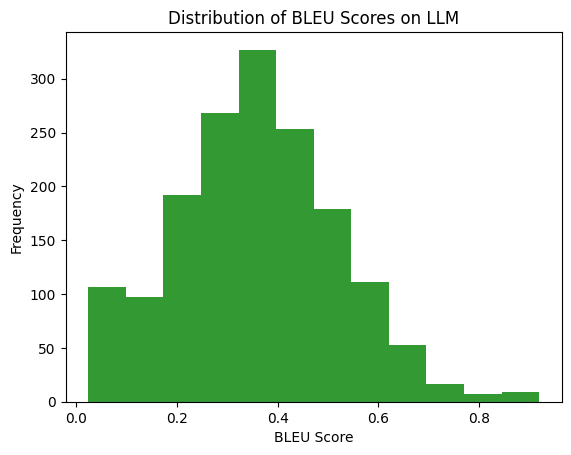

In [23]:
df['BLEU Score'].dropna().plot(kind='hist', bins=12, alpha=0.8, color= 'g')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('Distribution of BLEU Scores on LLM')
plt.show()

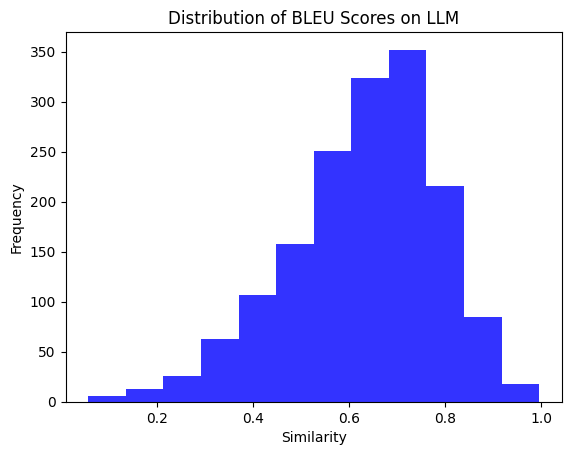

In [ ]:
df['Semantic Similarity'].dropna().plot(kind='hist', bins=12, alpha=0.8, color= 'b')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of BLEU Scores on LLM')
plt.show()